# BraTS2020 Brain Tumor Segmentation

Takes data from https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation, which is from the BraTS2020 Competition. <br><br> There are 4 goals of the project:
1. Manual segmentation labels of tumor sub-regions,
2. Clinical data of overall survival,
3. Clinical evaluation of progression status,
4. Uncertainty estimation for the predicted tumor sub-regions.

This file is for goal #1: Brain tumor segmentation utilizing the MRI data.

## 1. Download Dataset

In [ ]:
#! pip install kaggle

In [ ]:
# Set your working directory first so the data downloads where you want
#! kaggle datasets download awsaf49/brats20-dataset-training-validation

In [ ]:
#! unzip brats20-dataset-training-validation.zip

## 2. Load Data

### Setup Imports

In [90]:
import monai
import os
import torch
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import shutil
import tempfile
import time
import onnxruntime
import random
import cv2
import PIL
from PIL import Image, ImageOps
import nibabel as nib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate, resize
import glob
from tqdm import tqdm

from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch, Dataset
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric, compute_confusion_matrix_metric
from monai.networks.nets import SegResNet, UNet
from monai.utils import set_determinism
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    RandRotate90d,
    RandZoomd,
    Resized,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    ScaleIntensityd,
)


print_config()

MONAI version: 1.3.2
Numpy version: 1.23.5
Pytorch version: 2.2.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: /Users/<username>/opt/anaconda3/envs/monai_env/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.1
ITK version: 5.4.0
Nibabel version: 5.2.1
scikit-image version: 0.24.0
scipy version: 1.13.1
Pillow version: 10.4.0
Tensorboard version: 2.16.2
gdown version: 5.2.0
TorchVision version: 0.17.2
tqdm version: 4.66.5
lmdb version: 1.5.1
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.45.0
mlflow version: 2.16.2
pynrrd version: 1.0.0
clearml version: 1.16.4

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



### Setup Environment and Directory

In [54]:
os.environ["MONAI_DATA_DIRECTORY"] = os.path.expanduser('~/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Individual Work/Deep Learning/MONAI/Brain Tumor')
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)
# List all directories in the given path
folders = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))]

# Print the folders
print(folders)

/Users/jarrettsung/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Individual Work/Deep Learning/MONAI/Brain Tumor
['BraTS2020_ValidationData', '.ipynb_checkpoints', 'BraTS2020_TrainingData']


### Rename files that are incorrectly named
The segmentation file in "BraTS20_Training_355" folder has an incorrect name. Before moving forward, rename it to maintain similarity.

In [ ]:
# Set path to 355 folder for renaming
rename_PATH = root_dir + "/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/"
print(rename_PATH)

In [ ]:
old_name = rename_PATH + "W39_1998.09.19_Segm.nii"
new_name = rename_PATH + "BraTS20_Training_355_seg.nii"

try:
    os.rename(old_name, new_name)
    print("File has been re-named successfully!")
except:
    print("File is already renamed!")

## 3. Data Description

The Brain Tumor Segmentation (BraTS) 2020 dataset is a comprehensive collection of MRI scans designed for brain tumor segmentation tasks, specifically targeting glioma cases. For each patient, the dataset provides four different MRI sequences, or modalities, which offer distinct perspectives of the same brain region:

<b>T1-weighted (T1):</b> Standard anatomical imaging <br>
<b>T1 contrast-enhanced (T1ce):</b> Highlights contrast-enhanced regions<br>
<b>T2-weighted (T2):</b> Focuses on water content, useful for visualizing edema<br>
<b>T2-FLAIR (Fluid Attenuated Inversion Recovery):</b> Suppresses fluids, providing clearer visualization of lesions<br><br>
The dataset is also paired with expert-annotated segmentation masks that divide the tumor into different sub-regions:<br>

<b>Label 0:</b> Healthy tissue or background<br>
<b>Label 1:</b> Necrotic and non-enhancing tumor core (NCR/NET)<br>
<b>Label 2:</b> Peritumoral edema (ED)<br>
<b>Label 3:</b> Unused label (no pixels are associated with this class)<br>
<b>Label 4:</b> GD-enhancing tumor (ET)<br><br>
Since Label 3 is unused across the dataset, it is common practice to remap it to Label 4 to maintain label continuity and avoid gaps in the segmentation process.

## 4. Explore Data
Now that the files are named correctly, we can explore the data. <br><br> Let's take a look at patient 147 as an example.

In [55]:
# load .nii file as a numpy array
test_PATH = root_dir + "/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
test_image_flair = nib.load(test_PATH + "BraTS20_Training_147/BraTS20_Training_147_flair.nii").get_fdata()
print("Shape: ", test_image_flair.shape)
print("Dtype: ", test_image_flair.dtype)

Shape:  (240, 240, 155)
Dtype:  float64


In [56]:
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

Min:  0.0
Max:  497.0


#### Scale Data for Viewing
The max is a little high for our liking, so let's scale the data, just using minmax

In [57]:
scaler = MinMaxScaler()

In [58]:
# Scale the image and then reshape it back to original dimensions
# Keeps spatial structure while standardizing it
test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

In [59]:
print("Shape: ", test_image_flair.shape)
print("Dtype: ", test_image_flair.dtype)
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

Shape:  (240, 240, 155)
Dtype:  float64
Min:  0.0
Max:  1.0


Let's rescale the rest of the images from patient 147

In [60]:
# Rescale t1
test_image_t1 = nib.load(test_PATH + "BraTS20_Training_147/BraTS20_Training_147_t1.nii").get_fdata()
test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

# Rescale t1ce
test_image_t1ce = nib.load(test_PATH + "BraTS20_Training_147/BraTS20_Training_147_t1ce.nii").get_fdata()
test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

# Rescale t2
test_image_t2 = nib.load(test_PATH + "BraTS20_Training_147/BraTS20_Training_147_t2.nii").get_fdata()
test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

# Don't want to rescale the mask - let's explore it before doing anything to it
# Mask (seg)
test_image_seg = nib.load(test_PATH + "BraTS20_Training_147/BraTS20_Training_147_seg.nii").get_fdata()


#### View by slice
Now that we've rescaled, let's take a look at the images for a couple of different slices. Let's arbitrarily pick slice 95 and slice 105.

Slice number:  95
Modality:  (240, 240, 155)
Segmentation:  (240, 240, 155)


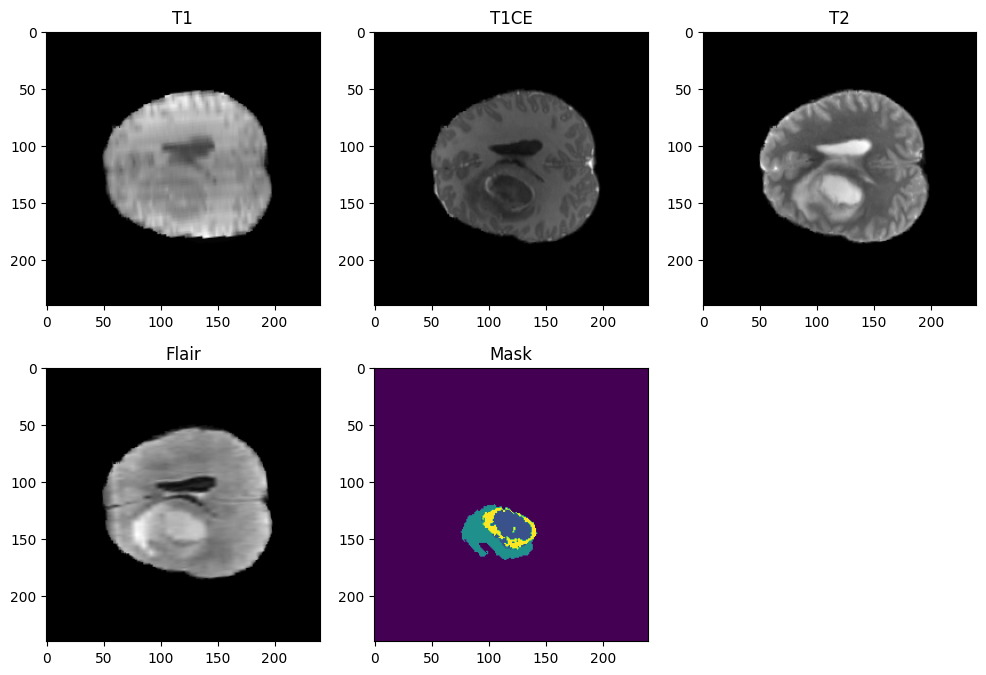

In [62]:
slice = 95

print("Slice number: ", str(slice)) 

# Let's also check the shapes of the images t1 and mask
# Modality shape
print("Modality: ", test_image_t1.shape)

# Segmentation shape
print("Segmentation: ", test_image_seg.shape)

plt.figure(figsize=(12,8))

# Plot T1
plt.subplot(2,3,1)
plt.imshow(test_image_t1[:,:,slice], cmap='gray')
plt.title('T1')

# Plot T1CE
plt.subplot(2,3,2)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1CE')

# Plot T2
plt.subplot(2,3,3)
plt.imshow(test_image_t2[:,:,slice], cmap='gray')
plt.title('T2')

# Plot FLAIR
plt.subplot(2,3,4)
plt.imshow(test_image_flair[:,:,slice], cmap='gray')
plt.title('Flair')

# Plot Mask (Seg)
plt.subplot(2,3,5)
plt.imshow(test_image_seg[:,:,slice])
plt.title('Mask')

plt.show()

Slice number:  105
Modality:  (240, 240, 155)
Segmentation:  (240, 240, 155)


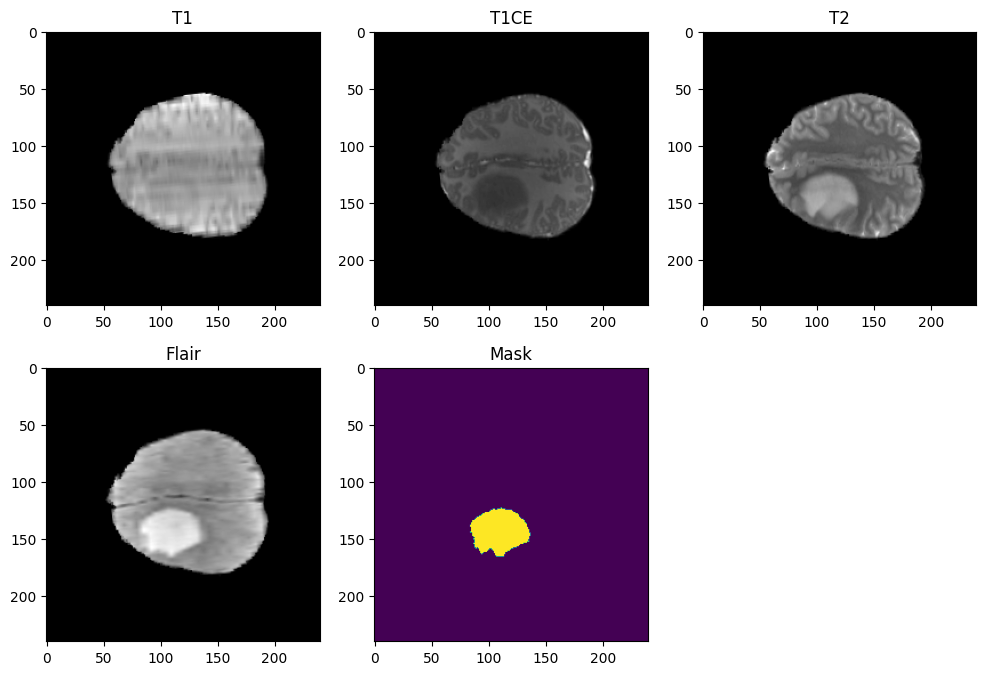

In [63]:
slice = 105

print("Slice number: ", str(slice)) 

# Let's also check the shapes of the images t1 and mask
# Modality shape
print("Modality: ", test_image_t1.shape)

# Segmentation shape
print("Segmentation: ", test_image_seg.shape)

plt.figure(figsize=(12,8))

# Plot T1
plt.subplot(2,3,1)
plt.imshow(test_image_t1[:,:,slice], cmap='gray')
plt.title('T1')

# Plot T1CE
plt.subplot(2,3,2)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1CE')

# Plot T2
plt.subplot(2,3,3)
plt.imshow(test_image_t2[:,:,slice], cmap='gray')
plt.title('T2')

# Plot FLAIR
plt.subplot(2,3,4)
plt.imshow(test_image_flair[:,:,slice], cmap='gray')
plt.title('Flair')

# Plot Mask (Seg)
plt.subplot(2,3,5)
plt.imshow(test_image_seg[:,:,slice])
plt.title('Mask')

plt.show()

#### View all slices
It's pretty easy to tell at this point that depending on the slice, the images will show different things. We can then take a look at all slices and see if each will give different information, important or not.

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1,1,1)

# Montage helps show all of the images
plt.imshow(rotate(montage(test_image_t2[:,:,:]), 90, resize=True), cmap='gray')
plt.show()

The sides of the image are dark, which means they don't contain much useful information. Let's remove 50 slices from each side to see if all important information is contained. Can adjust number of slices if needed.

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1,1,1)

# Let's remove 50 slices on each side since there's not much information from them
plt.imshow(rotate(montage(test_image_t2[50:-50,:,:]), 90, resize=True), cmap='gray')
plt.show()

#### Look at different viewpoints
Next, let's take a look at the different views of a single slice. We'll look at the transverse view (above), the frontal view, and the saggital view (side). <br> <br>
We do this because the different viewpoints can give us different understandings of the images.

In [ ]:
slice = 95

print("Slice: ", str(slice))

plt.figure(figsize=(12,8))

# Transverse view
plt.subplot(1,3,1)
plt.imshow(test_image_t2[:,:,slice], cmap='gray')
plt.title("Transverse View")

# Frontal view
plt.subplot(1,3,2)
plt.imshow(rotate(test_image_t2[:,slice,:], 90, resize=True), cmap='gray')
plt.title("Frontal View")

# Saggital view
plt.subplot(1,3,3)
plt.imshow(rotate(test_image_t2[slice,:,:], 90, resize=True), cmap='gray')
plt.title("Saggital View")

plt.show()

#### Segmented images
Now that we've viewed much of the data, let's focus on the segmented images.<br><br>
There are 4 important classes in the segmented images:
1. Not Tumor (class 0)
2. Non-Enhancing Tumor (class 1)
3. Edema (class 2)
4. Enhancing Tumor (class 4)<br>

We'll now take a look at each of them separately

In [ ]:
slice = 95
print("Slice: ", str(slice))

# Lets define the classes and the coloring scheme
cmap = matplotlib.colors.ListedColormap(['#500050', '#0096FF', '#00FF00', '#CCCC00'])
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

# Not Tumor (class 0)
seg_0 = test_image_seg.copy()
seg_0[seg_0 != 0] = np.nan

# Non-Enhancing Tumor (class 1)
seg_1 = test_image_seg.copy()
seg_1[seg_1 != 1] = np.nan

# Edema (class 2)
seg_2 = test_image_seg.copy()
seg_2[seg_2 != 2] = np.nan

# Enhancing Tumor (class 4)
seg_4 = test_image_seg.copy()
seg_4[seg_4 != 4] = np.nan

# Define class names for legend
class_names = ['class 0', 'class 1', 'class 2', 'class 4']
legend = [plt.Rectangle((0,0),1,1, color = cmap(i), label = class_names[i]) for i in range(len(class_names))] 


plt.figure(figsize=(20,20))

plt.subplot(1,5,1)
plt.imshow(test_image_seg[:,:,slice], cmap=cmap, norm=norm)
plt.title('Full Mask')
plt.legend(handles=legend, loc='lower left')

plt.subplot(1,5,2)
plt.imshow(seg_0[:,:,slice], cmap=cmap, norm=norm)
plt.title('Seg 0')
plt.legend(handles=legend, loc='lower left')

plt.subplot(1,5,3)
plt.imshow(seg_1[:,:,slice], cmap=cmap, norm=norm)
plt.title('Seg 1')
plt.legend(handles=legend, loc='lower left')

plt.subplot(1,5,4)
plt.imshow(seg_2[:,:,slice], cmap=cmap, norm=norm)
plt.title('Seg 2')
plt.legend(handles=legend, loc='lower left')

plt.subplot(1,5,5)
plt.imshow(seg_4[:,:,slice], cmap=cmap, norm=norm)
plt.title('Seg 4')
plt.legend(handles=legend, loc='lower left')

plt.show()

## 5. Split the Data

In [73]:
# Define the path to your training data directory
train_data_dir = root_dir + "/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

# Get all patient directories in the training set
train_dirs = sorted(glob.glob(os.path.join(train_data_dir, "BraTS20_Training_*")))

# Create a list of dictionaries, where each dictionary contains paths to the modalities and segmentation
train_and_test_files = []
for train_dir in train_dirs:
    data_dict = {
        "t1ce": os.path.join(train_dir, f"{os.path.basename(train_dir)}_t1ce.nii"),
        "flair": os.path.join(train_dir, f"{os.path.basename(train_dir)}_flair.nii"),
        "seg": os.path.join(train_dir, f"{os.path.basename(train_dir)}_seg.nii"),
    }
    train_and_test_files.append(data_dict)

# Print the number of training patients
print(f"Total number of patients: {len(train_and_test_files)}")

Total number of patients: 369


Since we don't have a defined test set, we can split the validation set randomly to get a train/val/test split to about 65/20/15

In [74]:
# Split the data into train/test and validation (20% validation)
train_test_files, val_files = train_test_split(train_and_test_files,test_size=0.2)

# Split the train/test into train (68% train) and test (12% test)
train_files, test_files = train_test_split(train_test_files,test_size=0.15)

In [75]:
# Print data distribution (Train: 68%, Test: 12%, Val: 20%)
print(f"Train length: {len(train_files)}")
print(f"Validation length: {len(val_files)}")
print(f"Test length: {len(test_files)}")

Train length: 250
Validation length: 74
Test length: 45


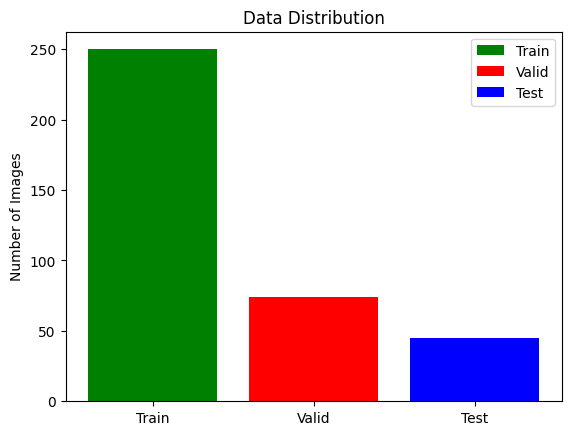

In [86]:
plt.bar(["Train","Valid","Test"],
        [len(train_files), len(val_files), len(test_files)],
        align='center',
        color=[ 'green','red', 'blue'],
        label=["Train", "Valid", "Test"]
       )

plt.legend()

plt.ylabel('Number of Images')
plt.title('Data Distribution')

plt.show()

## 6. Define Transformations for the data

The following transformations are applied to the **training**, **validation**, and **test datasets** to preprocess MRI images and their corresponding segmentation masks. These steps ensure the images are ready for training the model and evaluating its performance.

---

<b>Common Transformations</b><br>
Both training and validation pipelines share a few common transformations.

**`LoadImaged(keys=["t1ce", "flair", "seg"])`**
- Loads the T1CE and FLAIR MRI modalities along with the segmentation labels (masks) from the file paths. This transformation ensures that all necessary image volumes and their corresponding masks are loaded correctly.

**`EnsureChannelFirstd(keys=["t1ce", "flair", "seg"])`**
- Ensures that the input data (both MRI images and masks) have channels as the first dimension (e.g., `[C, H, W]` format). This is important for neural networks that expect inputs in a specific order (e.g., channel-first format for image data).

**`ScaleIntensityd(keys=["t1ce", "flair"])`**
- This transformation normalizes the intensity values of the T1CE and FLAIR images. This ensures that the pixel values are scaled to a common range, which helps the model learn better from the data by reducing the effects of variations in image intensity.

**`Resized(keys=["t1ce", "flair", "seg"], spatial_size=common_size)`**
- Resizes the images and masks to a common spatial size of `(240, 240, 160)`. This ensures that all input data have the same dimensions, which is required for batch processing during model training.

**`ReassignClasses()`**
- Custom class that reassigns the segmentation labels. In the BraTS dataset, class `4` (GD-enhancing tumor) is reassigned to class `3` (to maintain label continuity), while classes `1` and `2` are left unchanged.

**`EnsureTyped(keys=["t1ce", "flair", "seg"])`**
- Ensures that the data is converted into PyTorch tensors, which is necessary for compatibility with the deep learning model during training and evaluation.

**`AsDiscreted(keys=["seg"], to_onehot=4)`**
- Converts the segmentation labels to one-hot encoded format with four classes. This is essential for multi-class segmentation tasks where each pixel is classified into one of several categories (e.g., necrotic core, edema, enhancing tumor).

---

<b>Additional Training-Specific Transformations</b>

For the **training dataset**, additional augmentations are applied to improve the model's generalization capabilities.

**`RandFlipd(keys=["t1ce", "flair", "seg"], spatial_axis=0, prob=0.5)`**
- Randomly flips the images and masks along the specified axis (e.g., left-right flipping). This helps introduce variability into the training data, which can prevent overfitting.

**`RandRotate90d(keys=["t1ce","flair", "seg"], prob=0.5)`**
- Randomly rotates the images and segmentation masks by 90 degrees. Like flipping, this adds variation to the data, improving the model's ability to generalize.

**`RandZoomd(keys=["t1ce","flair", "seg"], min_zoom=0.9, max_zoom=1.1, prob=0.5)`**
- Randomly zooms in or out of the images and masks within a specified range. This ensures that the model learns to handle different scales of tumors and other features in the images.

---

<b>Additional Notes</b><br>
- **Training Augmentations** like flipping, rotating, and zooming are applied only to the training data to increase its variability. This helps the model generalize better during inference.
- **Validation and Test Transformations** do not include random augmentations to ensure consistency during evaluation.

These transformations collectively ensure that the input data is well-prepared for training and validation, with variability in training data and consistency in validation/test data.


In [129]:
common_size = (240, 240, 160)  # Ensure a common size for spatial dimensions

class ReassignClasses:
    def __call__(self, data):
        seg = data['seg']
        seg[seg == 4] = 3  # Reassign class 4 to class 3
        data['seg'] = seg
        return data

# Define transformations for training, validation, and test datasets
train_transforms = Compose(
    [
        LoadImaged(keys=["t1ce","flair", "seg"]),  # Load images from file paths
        EnsureChannelFirstd(keys=["t1ce","flair", "seg"]),  # Ensure channels are first
        ScaleIntensityd(keys=["t1ce","flair"]),  # Normalize intensity values
        Resized(keys=["t1ce", "flair", "seg"], spatial_size=common_size), # Ensure common size
        RandFlipd(keys=["t1ce","flair", "seg"], spatial_axis=0, prob=0.5),  # Random flip
        RandRotate90d(keys=["t1ce","flair", "seg"], prob=0.5),  # Random 90 degree rotation
        RandZoomd(keys=["t1ce","flair", "seg"], min_zoom=0.9, max_zoom=1.1, prob=0.5),  # Random zoom
        ReassignClasses(),
        AsDiscreted(keys=["seg"], to_onehot=4),
        EnsureTyped(keys=["t1ce","flair", "seg"]) # Ensure tensors
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["t1ce", "flair", "seg"]),  # Load images from file paths
        EnsureChannelFirstd(keys=["t1ce", "flair", "seg"]),  # Ensure channels are first
        ScaleIntensityd(keys=["t1ce", "flair"]),  # Normalize intensity values
        Resized(keys=["t1ce", "flair", "seg"], spatial_size=common_size),  # Resize images
        ReassignClasses(),  # Reassign segmentation labels
        EnsureTyped(keys=["t1ce", "flair", "seg"]),  # Ensure tensors
        AsDiscreted(keys=["seg"], to_onehot=4)  # One-hot encoding for segmentation
    ]
)

## 7. Create DataLoaders for split data

In [131]:
# Create MONAI datasets for training, new validation, and test sets
train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds = Dataset(data=val_files, transform=val_transforms)
test_ds = Dataset(data=test_files, transform=val_transforms)  # Test set with no augmentation

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=2, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=2, num_workers=0)

# Print data loader sizes
print(f"Training DataLoader size: {len(train_loader)}")
print(f"Validation DataLoader size: {len(val_loader)}")
print(f"Test DataLoader size: {len(test_loader)}")

Training DataLoader size: 125
Validation DataLoader size: 37
Test DataLoader size: 23


In [ ]:
for batch_data in train_loader:
    print(batch_data)
    break

In [ ]:
for batch_data in train_loader:
    inputs = batch_data["t1ce"]
    labels = batch_data["seg"]
    print(f"Input size: {inputs.shape}, Label size: {labels.shape}")
    if (inputs.shape != labels.shape): 
        print("Mismatch on t1ce")
        break
    inputs2 = batch_data["flair"]
    print(f"Input size: {inputs2.shape}, Label size: {labels.shape}")
    if (inputs2.shape != labels.shape): 
        print("Mismatch on flair")
        break

## 8. Create model, loss function, optimizer

We'll now be creating the <b>model</b>, <b>loss function</b>, and <b>optimizer</b> for our data. <br><br>
**`Model: UNet`**<br>
For this project, we are using <b>UNet</b>, a popular architecture in medical image segmentation tasks. UNet is specifically designed for tasks where the output needs to have the same spatial resolution as the input, like segmentation, where each pixel of the input corresponds to a class in the output. It uses an encoder-decoder structure with skip connections, which helps in capturing both high-level and low-level features efficiently, making it well-suited for segmenting complex structures like brain tumors from MRI scans.<br><br>
**`Loss Function: DiceLoss`**<br>
The <b>Dice Loss</b> is a great choice for image segmentation tasks. It directly optimizes the overlap between predicted and ground truth segmentations, making it particularly useful for medical segmentation where class imbalances (e.g., small tumor regions compared to larger healthy tissue) are common. Dice Loss works by maximizing the similarity between the predicted mask and the ground truth, focusing on the true positive overlap between them.<br><br>
**`Optimizer: Adam`**<br>
We are using the <b>Adam</b> optimizer for training. Adam is known for its efficiency in terms of both memory and computation, as well as for its ability to adapt the learning rate of each parameter based on the first and second moments of the gradients. This is particularly helpful in tasks like medical image segmentation, where models can require fine-tuning for complex data, such as MRI images, and Adam’s adaptive learning rate can make the training process more stable and faster compared to more basic optimizers like SGD.<br>

In [173]:
max_epochs = 20
val_interval = 1
VAL_AMP = False

# Define the model
device = torch.device("cpu")
model = UNet(
    spatial_dims=3,           # 3D UNet for 3D images
    in_channels=2,            # Input channels (T1CE and FLAIR)
    out_channels=4,           # Output channels (for 4 classes)
    channels=(8, 16, 32, 64, 128),  # Number of filters in each level
    strides=(2, 2, 2, 2),     # Strides for downsampling in each level
    num_res_units=2,          # Use residual connections
    dropout=0.2               # Dropout probability
).to(device)

# Define loss function, optimizer, learning rate scheduler
loss_function = DiceLoss(
    smooth_nr = 1,
    smooth_dr = 1e-5,
    squared_pred = True,
    to_onehot_y = False,
    sigmoid = False
)
# SGD optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
# Step LR
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# Metrics and post-processing
dice_metric = DiceMetric(include_background = True, reduction = "mean")
dice_metric_batch = DiceMetric(include_background = True, reduction = "mean_batch")

post_trans = Compose([
    Activations(softmax=True),           # Apply softmax to get class probabilities
    # AsDiscrete(argmax=True)              # Convert probabilities to class labels using argmax
    AsDiscrete(threshold = 0.25)           # Lower threshold for classes that aren't as prevalent
])

# Define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )
    return _compute(input)

torch.backends.cudnn.benchmark = False

## 9. Train the data

The training loop is the core process where the model learns from the data. It runs for a specified number of **epochs**, where each epoch represents one complete pass through the entire training dataset.

During each epoch, the data is processed in smaller groups called **batches**. This is done to make training more memory efficient and to allow for more stable updates to the model parameters. The model processes each batch individually, calculates the loss, and updates its parameters.

**Epoch loop:**  
The outer loop runs for a predefined number of epochs. Each epoch consists of processing all the data in batches. Multiple epochs are used because the model needs to see the data many times to learn meaningful patterns. The loop begins with setting the model to training mode using `model.train()`, ensuring that all the necessary layers (like dropout) behave correctly during training.

**Batch processing:**  
Within each epoch, the dataset is processed in batches. A batch is a subset of the dataset, usually smaller than the entire dataset, that can fit into memory. Each batch is loaded from the `train_loader` and consists of MRI scans and their corresponding segmentation masks. 

**Forward pass:**  
For each batch, the model makes predictions by performing a forward pass. This involves passing the batch of images through the layers of the model to get an output (in this case, a segmentation mask). The predicted output is compared to the true labels (segmentation masks) using a **loss function** (here, Dice Loss). The loss function measures how different the model’s predictions are from the ground truth.

**Backward pass (Backpropagation):**  
Once the loss is calculated, backpropagation is used to compute the gradients of the loss with respect to each of the model’s parameters. This step allows the model to understand how it should adjust its weights to minimize the error in future predictions. The `loss.backward()` call performs this gradient computation.

**Optimizer step:**  
After computing the gradients, the optimizer (Adam in this case) updates the model’s parameters based on these gradients. The `optimizer.step()` function performs this update, moving the model’s weights in the direction that reduces the loss.

**Epoch loss calculation:**  
During each epoch, the total loss is accumulated over all batches. After processing all the batches, the average loss for the epoch is calculated and stored. Monitoring the epoch loss helps in understanding whether the model is improving over time.

**Validation step:**  
After each epoch, the model is evaluated on a separate validation set. This step is crucial as it checks how well the model is generalizing to unseen data. The validation loop is similar to the training loop, but no gradients are calculated, and no weights are updated. The validation performance is used to track the model's improvement and prevent overfitting.

**Learning rate scheduling:**  
If a learning rate scheduler is used, the learning rate is adjusted after each epoch. This helps the model converge by starting with larger updates and gradually making smaller adjustments as training progresses.

**Saving the best model:**  
At the end of each epoch, the model's performance on the validation set is compared to previous epochs. If the model achieves a better validation performance (usually measured using a metric like the Dice score), the model’s parameters are saved. This ensures that the best version of the model, based on validation performance, is preserved for later use.


In [ ]:
best_metric = -1
best_metric_epoch = -1
best_metric_epoch_time = [[], [], []]
epoch_loss_val = []
metric_val = []
metric_val_tc = []
metric_val_wt = []
metric_val_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")

    model.train() # start training the model
    epoch_loss = 0
    step = 0

    # Iterate through batches
    for batch_data in train_loader:
        step_start = time.time()
        step += 1

        inputs = torch.cat([ 
                        batch_data["t1ce"].to(device), 
                        batch_data["flair"].to(device)], dim=1)  # Concatenating along the channel axis
        labels = batch_data["seg"].to(device)  # Segmentation labels

        optimizer.zero_grad() # Reset gradients

        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        # Backprop
        loss.backward()
        optimizer.step() # Update parameters

        # Accumulate total epoch loss
        epoch_loss += loss.item()
        
        # Update training progress
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )

     # Update learning rate scheduler
    lr_scheduler.step()

    # Calc/store average loss for epoch
    epoch_loss /= step
    epoch_loss_val.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # Validation at intervals
    if (epoch + 1) % val_interval == 0:
        model.eval() # Evaluation mode
        with torch.no_grad(): # Don't want gradients when validating
            for val_data in val_loader:
                val_inputs = torch.cat([
                    val_data["t1ce"].to(device),
                    val_data["flair"].to(device)], dim=1)  # Concatenating along the channel axis
                val_labels = val_data["seg"].to(device)  # Segmentation labels

                # Make prediction
                val_outputs = inference(val_inputs)

                # Post-process outputs
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]

                # Compute Dice metric for each batch
                dice_metric(y_pred = val_outputs, y = val_labels)
                dice_metric_batch(y_pred = val_outputs, y = val_labels)

            # Aggregate/store validation metrics
            metric = dice_metric.aggregate()
            curr_overall_dice = torch.mean(metric).item()
            metric_val.append(curr_overall_dice)

            # Aggregate metrics for this batch
            metric_batch = dice_metric_batch.aggregate()

            # Compute the mean of per-class Dice scores over the batch
            metric_val_tc = metric_batch[0].item()
            metric_val_wt = metric_batch[1].item()
            metric_val_et = metric_batch[2].item()

            curr_overall_dice_value = curr_overall_dice.item() if isinstance(curr_overall_dice, torch.Tensor) else curr_overall_dice
            metric_tc_value = metric_tc.item() if isinstance(metric_tc, torch.Tensor) else metric_tc
            metric_wt_value = metric_wt.item() if isinstance(metric_wt, torch.Tensor) else metric_wt
            metric_et_value = metric_et.item() if isinstance(metric_et, torch.Tensor) else metric_et

            metric_val_tc.append(metric_tc)
            metric_val_wt.append(metric_wt)
            metric_val_et.append(metric_et)
            
            # Reset metrics for next epoch
            dice_metric.reset()
            dice_metric_batch.reset()
            
            # Save model if current metric is the best
            if curr_overall_dice > best_metric:
                best_metric = curr_overall_dice
                best_metric_epoch = epoch + 1
                best_metric_epoch_time[0].append(best_metric)
                best_metric_epoch_time[1].append(best_metric_epoch)
                best_metric_epoch_time[2].append(time.time() - total_start)
                
                # Save model
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth")
                )
                print("saved new best metric model")
            
            # Print best metrics
            print(
                f"current epoch: {epoch + 1} current mean dice: {curr_overall_dice_value:.4f}"
                f" tc: {metric_tc_value:.4f} wt: {metric_wt_value:.4f} et: {metric_et_value:.4f}"
                f"\nbest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}"
            )
   
    # Time spent for each epoch
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")


# Save the lists as a pickle file
with open(os.path.join(root_dir, "training_metrics.pkl"), 'wb') as f:
    pickle.dump({
        'epoch_loss_val': epoch_loss_val,
        'metric_val': metric_val,
        'metric_val_tc': metric_val_tc,
        'metric_val_wt': metric_val_wt,
        'metric_val_et': metric_val_et,
    }, f)

print("Training metrics saved!")


# Calc total training time
total_time = time.time() - total_start
print(f"Total time: {total_time:.4f}")

----------
epoch 1/10
1/125, train_loss: 0.9627, step time: 11.8485
2/125, train_loss: 0.9463, step time: 9.1892
3/125, train_loss: 0.9344, step time: 7.7355
4/125, train_loss: 0.9266, step time: 7.4191
5/125, train_loss: 0.9011, step time: 7.6123
6/125, train_loss: 0.8985, step time: 7.6678
7/125, train_loss: 0.8792, step time: 7.5310
8/125, train_loss: 0.8858, step time: 7.7199
9/125, train_loss: 0.8694, step time: 8.0863
10/125, train_loss: 0.8626, step time: 9.5439
11/125, train_loss: 0.8523, step time: 11.3037
12/125, train_loss: 0.8417, step time: 8.2823
13/125, train_loss: 0.8388, step time: 7.7132
14/125, train_loss: 0.8254, step time: 7.7479
15/125, train_loss: 0.8228, step time: 8.3561
16/125, train_loss: 0.8213, step time: 9.7256
17/125, train_loss: 0.8086, step time: 7.9316
18/125, train_loss: 0.8012, step time: 7.8281
19/125, train_loss: 0.7955, step time: 8.1955
20/125, train_loss: 0.7897, step time: 7.7532
21/125, train_loss: 0.7771, step time: 8.3897
22/125, train_loss:

#### Plot Loss and Metric from training

In [175]:
# Load the saved metrics
with open(os.path.join(root_dir, "training_metrics.pkl"), 'rb') as f:
    metrics = pickle.load(f)

# Now you can access the lists
epoch_loss_val = metrics['epoch_loss_val']
metric_val = metrics['metric_val']
metric_val_tc = metrics['metric_val_tc']
metric_val_wt = metrics['metric_val_wt']
metric_val_et = metrics['metric_val_et']


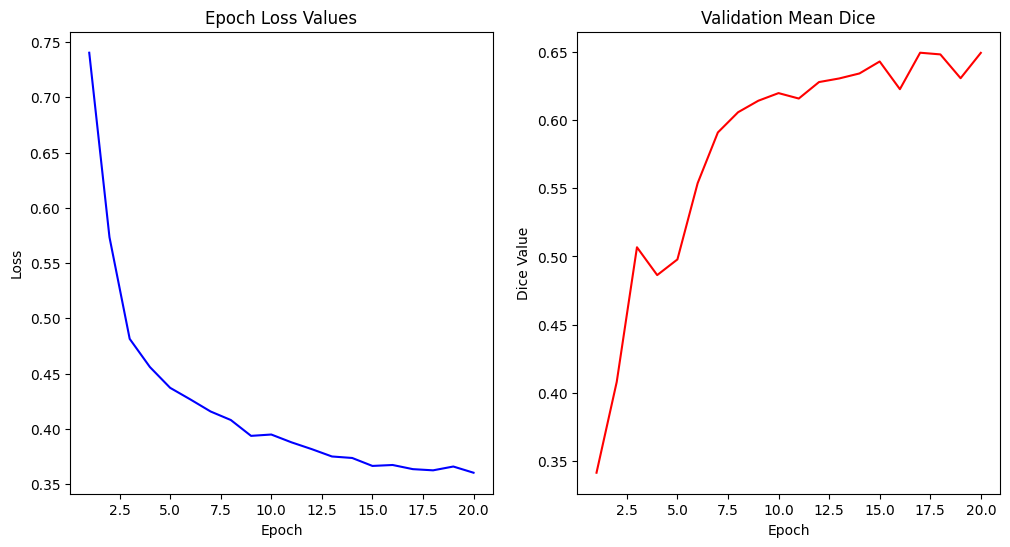

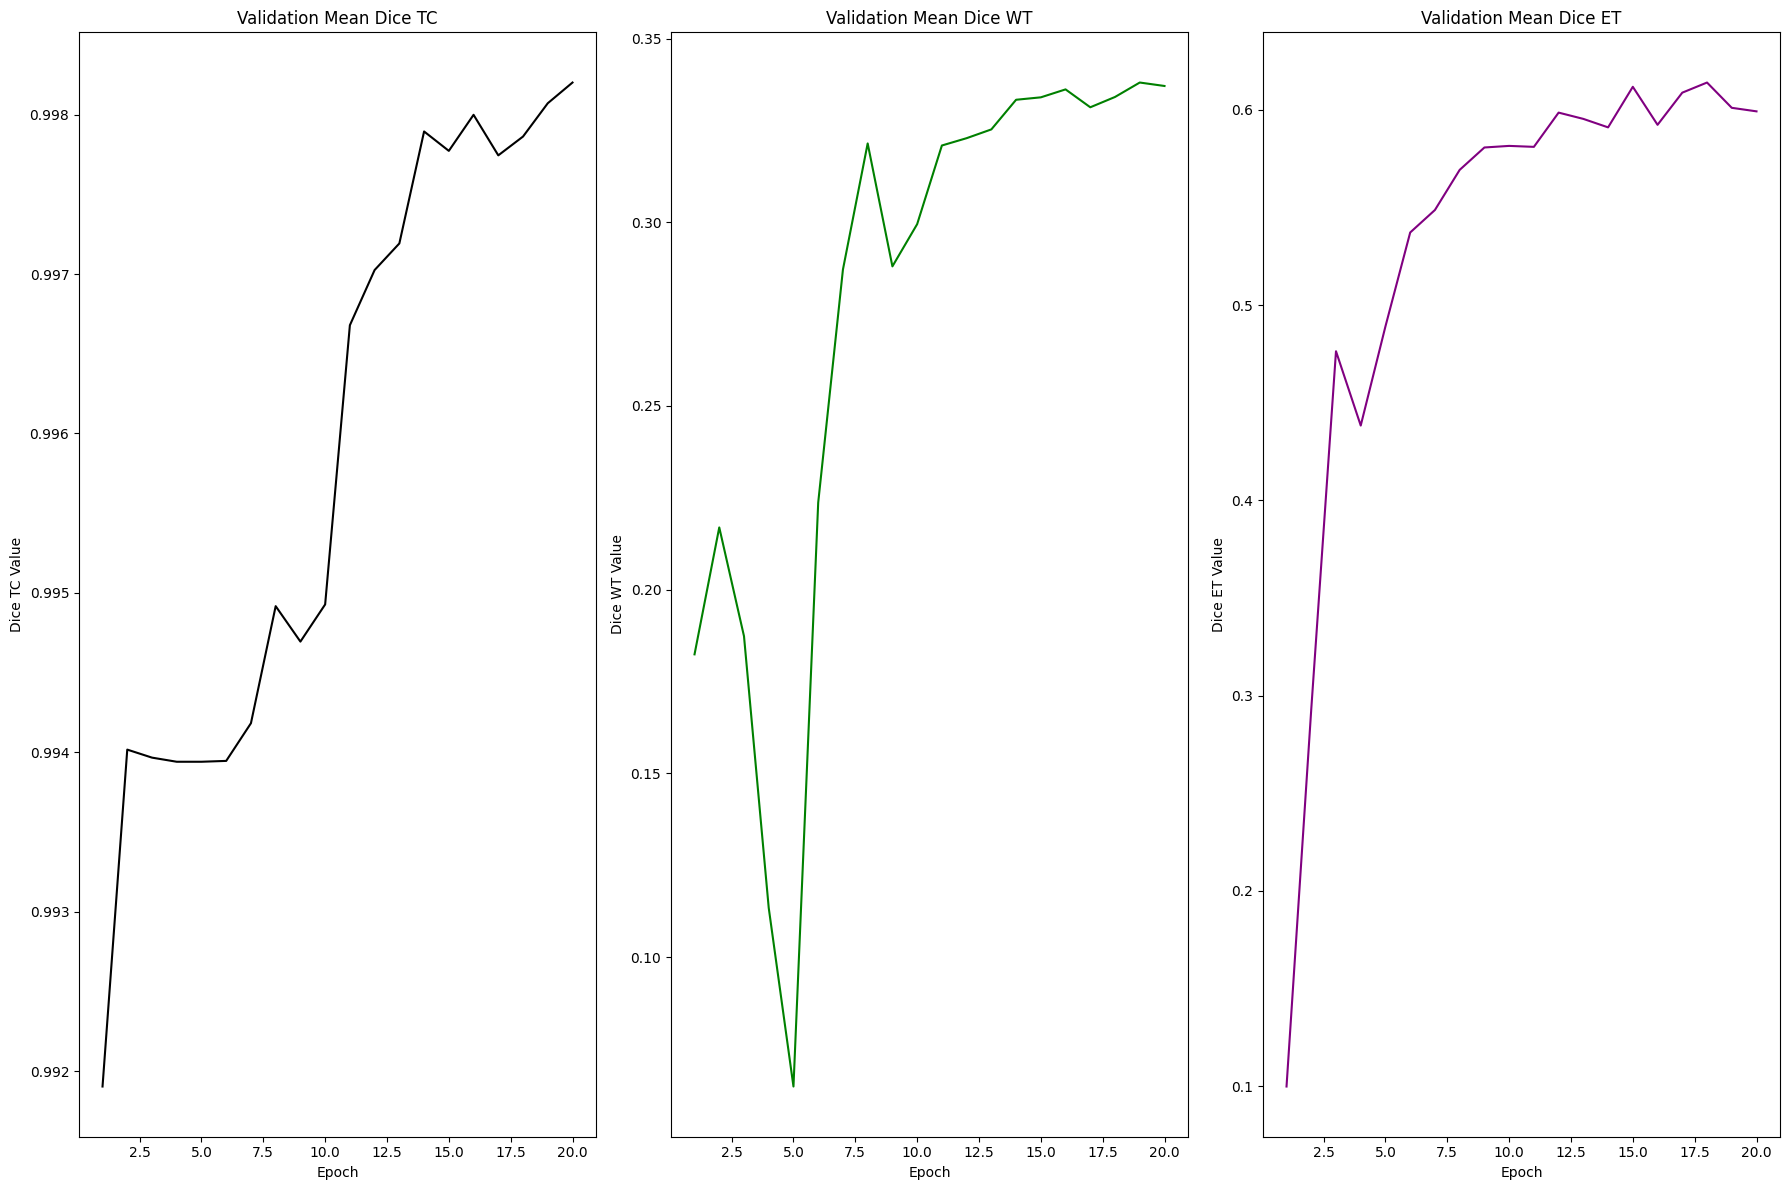

In [178]:
# Plot the variables for training evaluation
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot([i + 1 for i in range(len(epoch_loss_val))], epoch_loss_val, color='blue')
plt.title('Epoch Loss Values')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(val_interval * [i + 1 for i in range(len(epoch_loss_val))], metric_val, color='red')
plt.title('Validation Mean Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice Value')

plt.figure(figsize=(18,12))
plt.subplot(1,3,1)
plt.plot(val_interval * [i + 1 for i in range(len(epoch_loss_val))], metric_val_tc, color='black')
plt.title('Validation Mean Dice TC')
plt.xlabel('Epoch')
plt.ylabel('Dice TC Value')

plt.subplot(1,3,2)
plt.plot(val_interval * [i + 1 for i in range(len(epoch_loss_val))], metric_val_wt, color='green')
plt.title('Validation Mean Dice WT')
plt.xlabel('Epoch')
plt.ylabel('Dice WT Value')

plt.subplot(1,3,3)
plt.plot(val_interval * [i + 1 for i in range(len(epoch_loss_val))], metric_val_et, color='purple')
plt.title('Validation Mean Dice ET')
plt.xlabel('Epoch')
plt.ylabel('Dice ET Value')

plt.tight_layout()
plt.show()

#### Debugging training

In [ ]:
# Use a smaller subset of data for debugging
small_train_files = train_files[:10]  # Just take the first 10 patients
small_val_files = val_files[:5]  # Just take 5 for validation
small_test_files = test_files

# Create DataLoaders for the smaller datasets
small_train_loader = DataLoader(Dataset(data=small_train_files, transform=train_transforms), batch_size=1, shuffle=True, num_workers=0)
small_val_loader = DataLoader(Dataset(data=small_val_files, transform=val_transforms), batch_size=1, shuffle=False, num_workers=0)
small_test_loader = DataLoader(Dataset(data=small_test_files, transform=val_transforms), batch_size=1, shuffle=False, num_workers=0)



In [ ]:
class ReassignClasses:
    def __call__(self, data):
        seg = data['seg']
        #print(f"Seg before reassignment: {seg.shape} -- {type(seg)}")  # Debug print
        seg[seg == 4] = 3  # Reassign class 4 to class 3
        data['seg'] = seg
        #print(f"Seg after reassignment: {seg.shape} -- {type(seg)}")  # Debug print
        return data

val_transforms = Compose(
    [
        LoadImaged(keys=["t1ce", "flair", "seg"]),  # Load images from file paths
        EnsureChannelFirstd(keys=["t1ce", "flair", "seg"]),  # Ensure channels are first
        ScaleIntensityd(keys=["t1ce", "flair"]),  # Normalize intensity values
        Resized(keys=["t1ce", "flair", "seg"], spatial_size=common_size),  # Resize images
        ReassignClasses(),  # Reassign segmentation labels
        EnsureTyped(keys=["t1ce", "flair", "seg"]),  # Ensure tensors
        AsDiscreted(keys=["seg"], to_onehot=4)  # One-hot encoding for segmentation
    ]
)



In [ ]:
for val_data in small_val_loader:
    print(val_data)  # Print the data dictionary to inspect what is being passed
    val_inputs, val_labels = (
        val_data["t1ce"].to(device),
        val_data["seg"].to(device)
    )
    print(f"Validation Inputs: {val_inputs.shape}")
    print(f"Validation Labels: {val_labels.shape}")

In [128]:


# Define Dice metric for debugging
dice_metric = DiceMetric(include_background = True, reduction = "mean")
dice_metric_batch = DiceMetric(include_background = True, reduction = "mean_batch")

# Post-processing for outputs
post_trans = Compose([
    Activations(softmax=True),           # Apply softmax to get class probabilities
    AsDiscrete(threshold=0.2)              # Convert probabilities to class labels using argmax
])

# Set model to evaluation mode
model.eval()

# Placeholder lists to store metrics
metric_val = []
metric_val_tc = []
metric_val_wt = []
metric_val_et = []

total_start = time.time()

# Start the validation loop
with torch.no_grad():  # Disable gradient computation
    print("Starting validation...")
    for idx, val_data in enumerate(val_loader):
        val_start = time.time()
        
        # Prepare validation inputs by concatenating T1CE and FLAIR along the channel axis
        val_inputs = torch.cat([
            val_data['t1ce'].to(device),
            val_data['flair'].to(device)], dim=1)
        
        val_labels = val_data['seg'].to(device)  # Get the segmentation labels
        
        # Forward pass
        val_outputs = model(val_inputs)
        # print(f"Val Ouputs shape before post-processing: {len(val_outputs)}")
        # print(f"Val Outputs before post-processing: {val_outputs}")
        
        # Post-processing outputs
        val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]

        # print(f"Val Inputs shape: {val_labels.shape}")
        # print(f"Val Ouputs shape: {len(val_outputs)}")
        # print(f"Val Outputs: {val_outputs}")
        
        # Compute Dice metrics
        dice_metric(y_pred=val_outputs, y=val_labels)
        dice_metric_batch(y_pred=val_outputs, y=val_labels)
        
        # Aggregate and store validation metrics
        metric = dice_metric.aggregate()
        overall_dice = torch.mean(metric).item()
        metric_val.append(overall_dice)

        # Per-class Dice metrics
        metric_batch = dice_metric_batch.aggregate()
        print(f"Metric batch length: {len(metric_batch)}")
        print(f"Metric batch values: {metric_batch}")
        
        #if len(metric_batch) >= 3:  # Handle case if fewer classes
        # metric_tc = metric_batch[0].item()  # Tumor Core
        # metric_wt = torch.mean(metric_batch[1]).item()  # Whole Tumor
        # metric_et = metric_batch[2].item()  # Enhancing Tumor
        
        # Compute the mean of per-class Dice scores over the batch
        metric_tc = torch.mean(metric_batch[:, 0]).item()  # Tumor Core
        metric_wt = torch.mean(metric_batch[:, 1]).item()  # Whole Tumor
        metric_et_1 = metric_batch[0, 2] # Enhancing Tumor
        metric_et_2 = metric_batch[1, 2]
        if torch.isnan(metric_et_1):
            metric_et_1 = torch.tensor(0.0)
        else:
            metric_et_1 = metric_et_1.item()  # Convert to scalar if not NaN

        # Check if metric_et_2 is NaN and set to 0 if NaN
        if torch.isnan(metric_et_2):
            metric_et_2 = torch.tensor(0.0)
        else:
            metric_et_2 = metric_et_2.item()  # Convert to scalar if not NaN
        metric_et = (metric_et_1 + metric_et_2) / 2

        print(metric_et)
        metric_val_tc.append(metric_tc)
        metric_val_wt.append(metric_wt)
        metric_val_et.append(metric_et)
        
        # Reset metrics for next iteration
        dice_metric.reset()
        dice_metric_batch.reset()

        # Print validation progress
        print(
            f"Validation batch {idx + 1} | Time: {(time.time() - val_start):.4f} seconds"
            f" | Dice Mean: {overall_dice:.4f}"
            f" | TC: {metric_tc:.4f}, WT: {metric_wt:.4f}, ET: {metric_et:.4f}"
        )

# Calculate and print final metrics
print("\nFinal Validation Metrics:")
print(f"Mean Dice: {sum(metric_val) / len(metric_val):.4f}")
print(f"Mean Dice TC: {sum(metric_val_tc) / len(metric_val_tc):.4f}")
print(f"Mean Dice WT: {sum(metric_val_wt) / len(metric_val_wt):.4f}")
print(f"Mean Dice ET: {sum(metric_val_et) / len(metric_val_et):.4f}")

print(f"Total validation time: {(time.time() - total_start):.4f} seconds")


Starting validation...
Metric batch length: 2
Metric batch values: tensor([[0.0457, 0.1299, 0.0039],
        [0.5554, 0.1595, 0.3478]])
0.17586709384340793
Validation batch 1 | Time: 3.2209 seconds | Dice Mean: 0.2070 | TC: 0.3005, WT: 0.1447, ET: 0.1759
Metric batch length: 2
Metric batch values: tensor([[0.4079, 0.1095, 0.0330],
        [0.1253, 0.2101, 0.1991]])
0.1160323191434145
Validation batch 2 | Time: 3.2423 seconds | Dice Mean: 0.1808 | TC: 0.2666, WT: 0.1598, ET: 0.1160
Metric batch length: 2
Metric batch values: tensor([[0.0954, 0.1893, 0.0354],
        [0.1940, 0.1788, 0.3574]])
0.19638073444366455
Validation batch 3 | Time: 3.1722 seconds | Dice Mean: 0.1751 | TC: 0.1447, WT: 0.1841, ET: 0.1964
Metric batch length: 2
Metric batch values: tensor([[0.1633, 0.1183, 0.3364],
        [0.1441, 0.1622, 0.1353]])
0.23589758574962616
Validation batch 4 | Time: 3.2298 seconds | Dice Mean: 0.1766 | TC: 0.1537, WT: 0.1402, ET: 0.2359
Metric batch length: 2
Metric batch values: tensor

In [ ]:

for batch_data in small_train_loader:
    inputs = torch.cat([ 
                        batch_data["t1ce"].to(device), 
                        batch_data["flair"].to(device)], dim=1)
    labels = batch_data["seg"].to(device)
    
    print(f"Input shape: {inputs.shape}")
    print(f"Labels shape: {labels.shape}")
    #break  # Only run the first batch for debugging


In [ ]:
best_metric = -1
best_metric_epoch = -1
best_metric_epoch_time = [[], [], []]
epoch_loss_val = []
metric_val = []
metric_val_tc = []
metric_val_wt = []
metric_val_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")

    model.train() # start training the model
    epoch_loss = 0
    step = 0

    # Iterate through batches
    for batch_data in small_train_loader:
        step_start = time.time()
        step += 1

        inputs = torch.cat([ 
                        batch_data["t1ce"].to(device), 
                        batch_data["flair"].to(device)], dim=1)  # Concatenating along the channel axis
        labels = batch_data["seg"].to(device)  # Segmentation labels

        optimizer.zero_grad() # Reset gradients

        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        # Backprop
        loss.backward()
        optimizer.step() # Update parameters

        # Accumulate total epoch loss
        epoch_loss += loss.item()
        
        # Update training progress
        print(
            f"{step}/{10 // small_train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )

     # Update learning rate scheduler
    lr_scheduler.step()

    # Calc/store average loss for epoch
    epoch_loss /= step
    epoch_loss_val.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # Validation at intervals
    if (epoch + 1) % val_interval == 0:
        model.eval() # Evaluation mode
        with torch.no_grad(): # Don't want gradients when validating
            for val_data in small_val_loader:
                val_inputs = torch.cat([
                    val_data["t1ce"].to(device),
                    val_data["flair"].to(device)], dim=1)  # Concatenating along the channel axis
                val_labels = val_data["seg"].to(device)  # Segmentation labels

                # Make prediction
                val_outputs = inference(val_inputs)

                # Post-process outputs
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]

                # Compute Dice metric for each batch
                dice_metric(y_pred = val_outputs, y = val_labels)
                dice_metric_batch(y_pred = val_outputs, y = val_labels)

            # Aggregate/store validation metrics
            metric = dice_metric.aggregate().item()
            metric_val.append(metric)

            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_val_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_val_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_val_et.append(metric_et)
            
            # Reset metrics for next epoch
            dice_metric.reset()
            dice_metric_batch.reset()
            
            # Save model if current metric is the best
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metric_epoch_time[0].append(best_metric)
                best_metric_epoch_time[1].append(best_metric_epoch)
                best_metric_epoch_time[2].append(time.time() - total_start)
                
                # Save model
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth")
                )
                print("saved new best metric model")

            # Print best metrics
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}"
            )
   
    # Time spent for each epoch
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")


# Calc total training time
total_time = time.time() - total_start
print(f"Total time: {total_time:.4f}")

## 10. Evaluate the Model on Test Set

Now that we have trained our model, we will evaluate it on the test set, again using Dice as our metric

In [83]:
# Load the best model
model.load_state_dict(torch.load(root_dir + "/best_metric_model.pth", map_location=device))

<All keys matched successfully>

In [84]:
# Metrics for evaluation
dice_metric = DiceMetric(include_background = True, reduction = "mean")
dice_metric_batch = DiceMetric(include_background = True, reduction = "mean_batch")

# Post-processing: apply activation and thresholding for segmentation
post_trans = Compose([
    Activations(softmax=True),           # Apply softmax to get class probabilities
    # AsDiscrete(argmax=True)              # Convert probabilities to class labels using argmax
    AsDiscrete(threshold = 0.25)           # Lower threshold for classes that aren't as prevalent
])
model.eval()  # Set model to evaluation mode
dice_scores = []

with torch.no_grad():
    for idx, test_data in enumerate(test_loader):
        # Prepare test inputs by concatenating T1CE and FLAIR along the channel axis
        test_inputs = torch.cat([
            test_data['t1ce'].to(device),
            test_data['flair'].to(device)], dim=1) 
        
        test_labels = test_data['seg'].to(device)  # Get segmentation labels
        
        # Forward pass through the model
        outputs = model(test_inputs)

        # Post-processing outputs
        outputs = [post_trans(i) for i in decollate_batch(outputs)]

        # Compute Dice metric for this batch
        dice_metric(y_pred=outputs, y=test_labels)
        
        # Get the Dice score for the batch and append to dice_scores list
        dice_score_batch = dice_metric.aggregate().mean().item()
        dice_scores.append(dice_score_batch)

        # Reset the dice metric for the next batch
        dice_metric.reset()

        print(f"Dice score for batch {idx + 1}: {dice_score_batch:.4f}")

# Calculate the final average Dice score across all batches
final_dice_score = sum(dice_scores) / len(dice_scores) if dice_scores else 0.0
print(f"Final Dice score on test set: {final_dice_score:.4f}")


Dice score for batch 1: 0.0000
Dice score for batch 2: 0.0000
Dice score for batch 3: 0.0000
Dice score for batch 4: 0.0000


KeyboardInterrupt: 

### Visualize the model evaluation

In [46]:
def plot_seg(image_seg, slice_idx):
    # Lets define the classes and the coloring scheme
    cmap = matplotlib.colors.ListedColormap(['#500050', '#0096FF', '#00FF00', '#CCCC00'])
    norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

    image_seg = image_seg.cpu().numpy()  # Convert to NumPy for visualization

    # Combine the channels into a full mask
    # Start with an empty mask (assume class 0, non-tumor by default)
    full_mask = np.zeros(image_seg[0].shape, dtype=np.int8)
    
    # Apply each class label to the appropriate voxels
    full_mask[image_seg[1] == 1] = 1  # Non-Enhancing Tumor (class 1)
    full_mask[image_seg[2] == 2] = 2  # Edema (class 2)
    full_mask[image_seg[3] == 4] = 4  # Enhancing Tumor (class 4)

    # Not Tumor (class 0)
    seg_0 = np.copy(image_seg[0])
    seg_0[seg_0 != 0] = np.nan
    
    # Non-Enhancing Tumor (class 1)
    seg_1 = np.copy(image_seg[1])
    seg_1[seg_1 != 1] = np.nan
    
    # Edema (class 2)
    seg_2 = np.copy(image_seg[2])
    seg_2[seg_2 != 2] = np.nan
    
    # Enhancing Tumor (class 4)
    seg_4 = np.copy(image_seg[3])
    seg_4[seg_4 != 3] = np.nan
    
    # Define class names for legend
    class_names = ['class 0', 'class 1', 'class 2', 'class 4']
    legend = [plt.Rectangle((0,0),1,1, color = cmap(i), label = class_names[i]) for i in range(len(class_names))] 
    
    
    plt.figure(figsize=(20,20))
    
    plt.subplot(1,5,1)
    plt.imshow(full_mask[:,:,slice_idx], cmap=cmap, norm=norm)
    plt.title('Full Mask')
    plt.legend(handles=legend, loc='lower left')
    
    plt.subplot(1,5,2)
    plt.imshow(seg_0[:,:,slice_idx], cmap=cmap, norm=norm)
    plt.title('Seg 0')
    plt.legend(handles=legend, loc='lower left')
    
    plt.subplot(1,5,3)
    plt.imshow(seg_1[:,:,slice_idx], cmap=cmap, norm=norm)
    plt.title('Seg 1')
    plt.legend(handles=legend, loc='lower left')
    
    plt.subplot(1,5,4)
    plt.imshow(seg_2[:,:,slice_idx], cmap=cmap, norm=norm)
    plt.title('Seg 2')
    plt.legend(handles=legend, loc='lower left')
    
    plt.subplot(1,5,5)
    plt.imshow(seg_4[:,:,slice_idx], cmap=cmap, norm=norm)
    plt.title('Seg 4')
    plt.legend(handles=legend, loc='lower left')
    
    plt.show()



In [183]:
# RECOMBINING ONE-HOT BACK TO ORIGINAL
def plot_seg(image_seg, slice_idx):
    # Recombine the one-hot encoded segmentation back into the original multi-class format
    image_seg = torch.argmax(image_seg, dim=0).cpu().numpy()  # Convert back to multi-class

    # Define classes and color scheme
    cmap = matplotlib.colors.ListedColormap(['#500050', '#0096FF', '#00FF00', '#B10000'])
    norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

    # # Create segmentation masks for each class
    # seg_0 = image_seg.copy()
    # seg_0[seg_0 != 0] = np.nan

    # seg_1 = image_seg.copy()
    # seg_1[seg_1 != 1] = np.nan

    # seg_2 = image_seg.copy()
    # seg_2[seg_2 != 2] = np.nan

    # seg_3 = image_seg.copy()
    # seg_3[seg_3 != 3] = np.nan

    # Create segmentation masks for each class
    seg_0 = np.ma.masked_where(image_seg != 0, image_seg)  # Mask all values except 0
    seg_1 = np.ma.masked_where(image_seg != 1, image_seg)  # Mask all values except 1
    seg_2 = np.ma.masked_where(image_seg != 2, image_seg)  # Mask all values except 2
    seg_3 = np.ma.masked_where(image_seg != 3, image_seg)  # Mask all values except 3

    # Define class names for legend
    class_names = ['class 0', 'class 1', 'class 2', 'class 3']
    legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

    plt.figure(figsize=(20, 20))

    # Plot the full recombined mask
    plt.subplot(1, 5, 1)
    plt.imshow(image_seg[:, :, slice_idx], cmap=cmap, norm=norm)
    plt.title('Full Mask')
    plt.legend(handles=legend, loc='lower left')

    # Plot each class separately
    plt.subplot(1, 5, 2)
    plt.imshow(seg_0[:, :, slice_idx], cmap=cmap, norm=norm)
    plt.title('Seg 0')

    plt.subplot(1, 5, 3)
    plt.imshow(seg_1[:, :, slice_idx], cmap=cmap, norm=norm)
    plt.title('Seg 1')

    plt.subplot(1, 5, 4)
    plt.imshow(seg_2[:, :, slice_idx], cmap=cmap, norm=norm)
    plt.title('Seg 2')

    plt.subplot(1, 5, 5)
    plt.imshow(seg_3[:, :, slice_idx], cmap=cmap, norm=norm)
    plt.title('Seg 3')

    plt.show()


In [22]:
def plot_segmentation_results(inputs, labels, outputs, idx):
    # Display an image slice with the prediction and ground truth
    slice_idx = inputs.shape[4] // 2  # Use middle slice for visualization

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    cmap = matplotlib.colors.ListedColormap(['#500050', '#0096FF', '#00FF00', '#CCCC00'])
    
    # Plot original T1CE image
    ax[0].imshow(inputs[0, 0, :, :, slice_idx].cpu(), cmap='gray')
    ax[0].set_title(f'T1CE - Input {idx+1}')
    
    # Plot ground truth
    ax[1].imshow(labels[0, 0, :, :, slice_idx].cpu(), cmap=cmap)
    ax[1].set_title(f'Ground Truth - Label {idx+1}')
    
    # Plot model prediction
    ax[2].imshow(outputs[0][0, :, :, slice_idx].cpu(), cmap=cmap)
    ax[2].set_title(f'Prediction - Output {idx+1}')
    
    plt.show()




Input and output for data point 1/23
Input label shape: torch.Size([2, 4, 240, 240, 160])
Output shape (after decollate): torch.Size([1, 240, 240, 160])


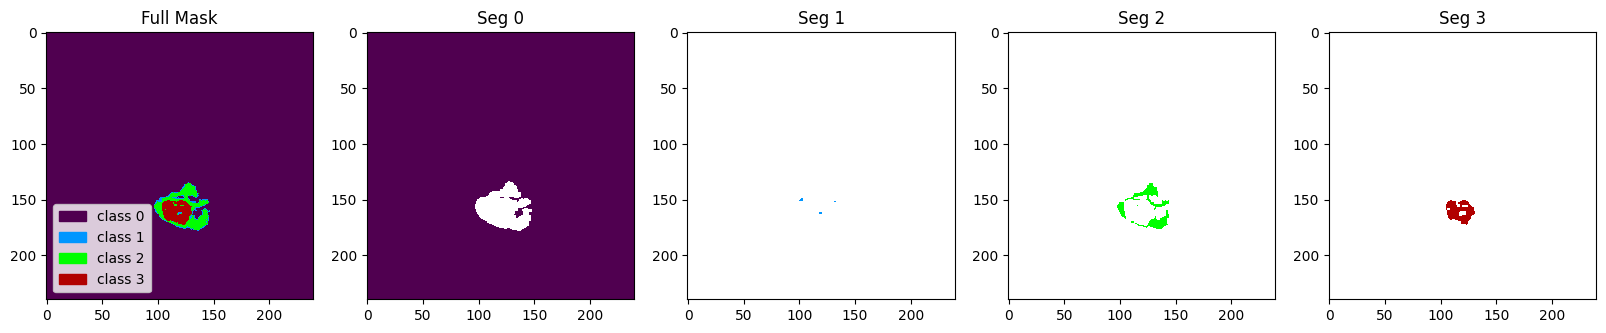

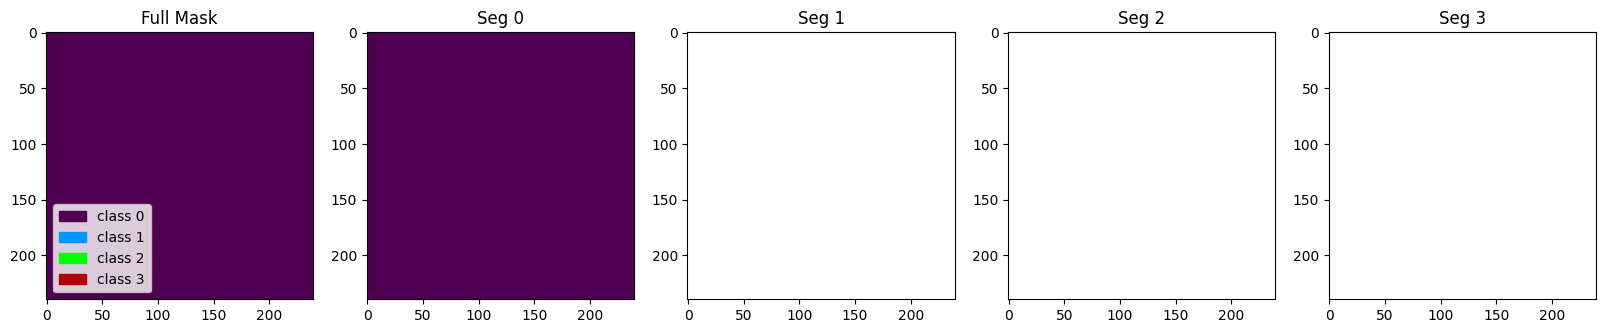

Input and output for data point 2/23
Input label shape: torch.Size([2, 4, 240, 240, 160])
Output shape (after decollate): torch.Size([1, 240, 240, 160])


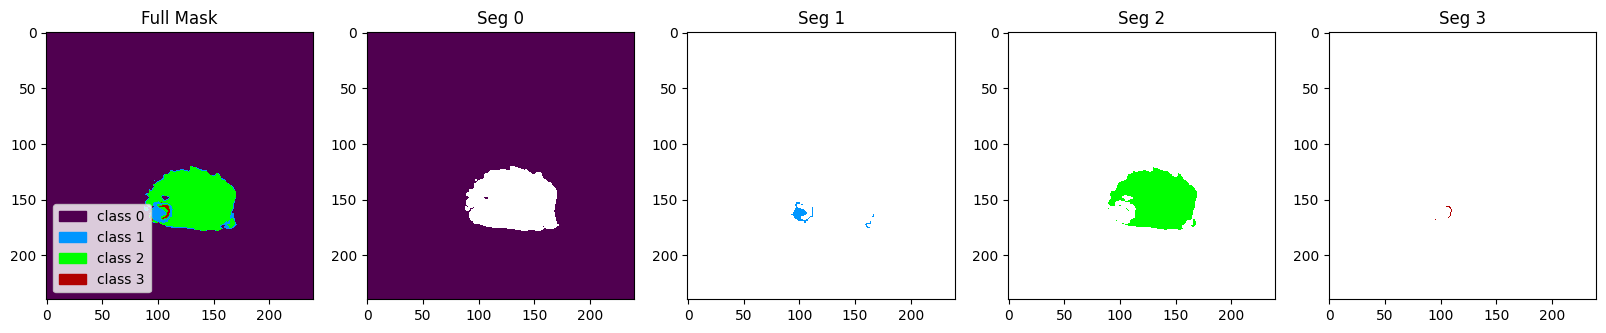

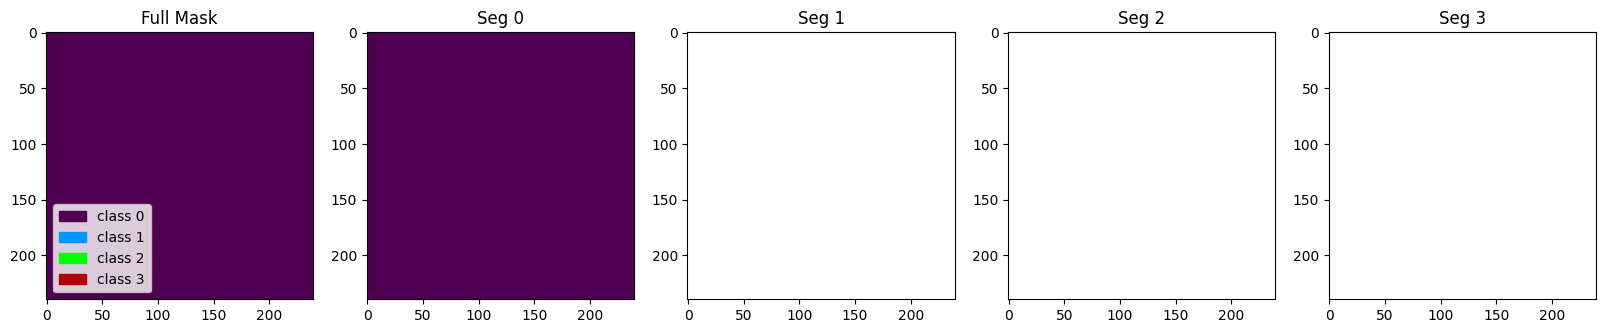

Input and output for data point 3/23
Input label shape: torch.Size([2, 4, 240, 240, 160])
Output shape (after decollate): torch.Size([1, 240, 240, 160])


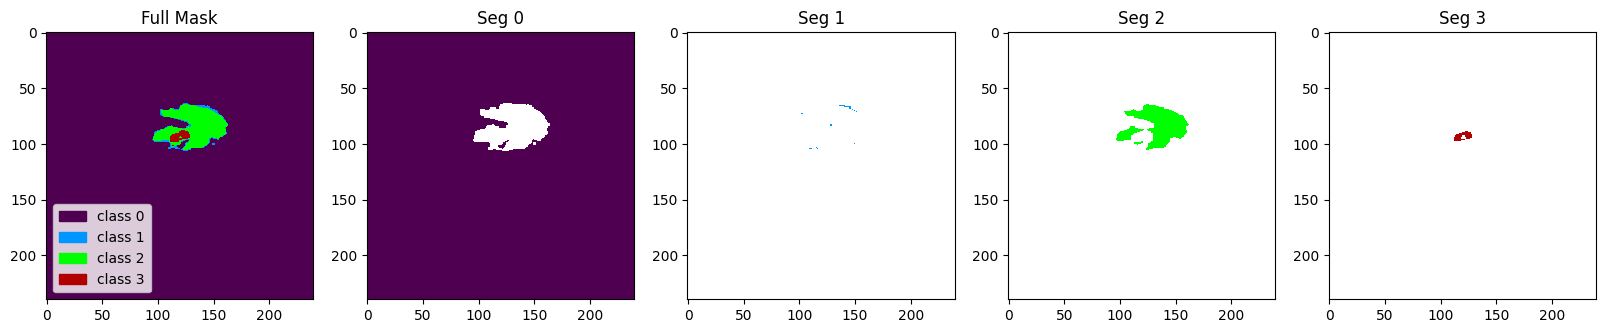

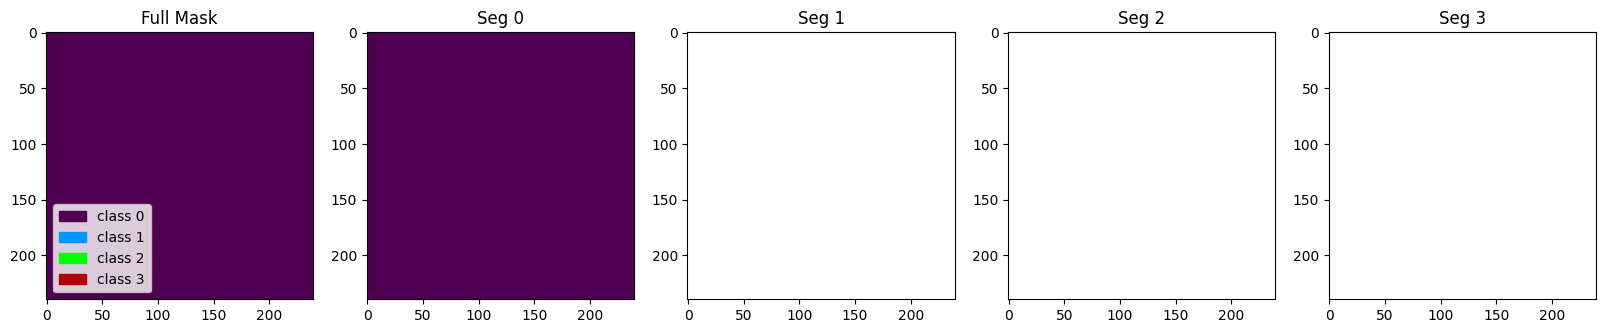

Input and output for data point 4/23
Input label shape: torch.Size([2, 4, 240, 240, 160])
Output shape (after decollate): torch.Size([1, 240, 240, 160])


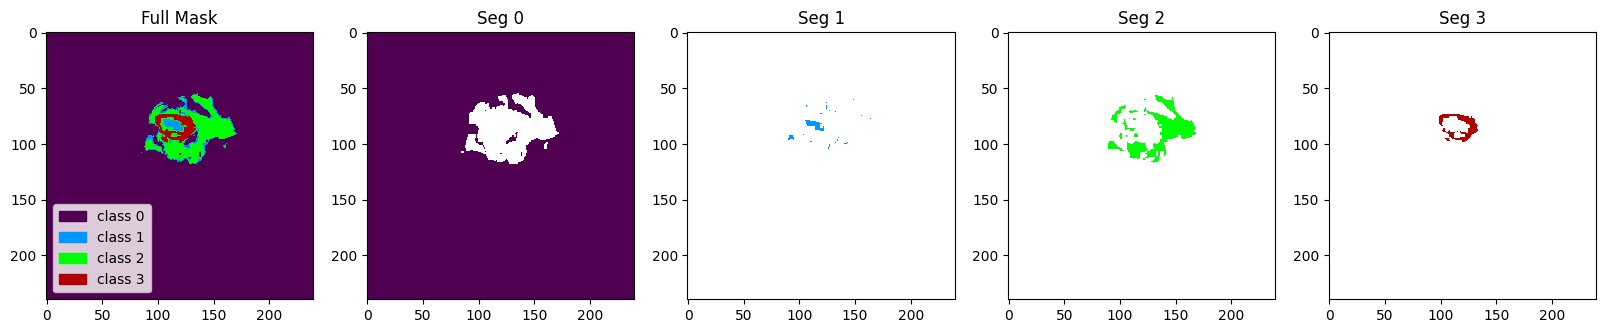

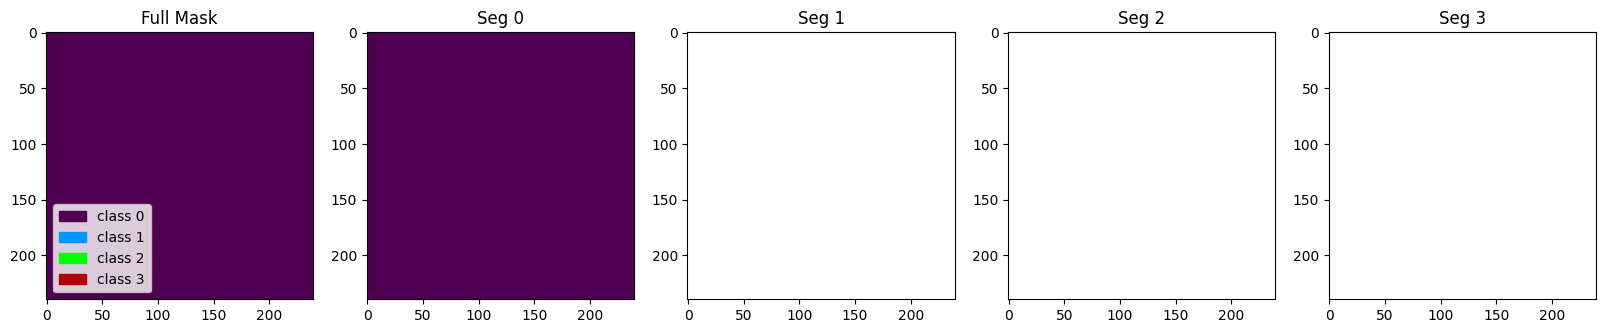

In [ ]:
# After each batch or at the end of testing
post_trans = Compose([
    Activations(softmax=True),           # Apply softmax to get class probabilities
    AsDiscrete(argmax=True)  # Convert probabilities to class labels using argmax
    # AsDiscrete(threshold=0.5)
])
for idx, test_data in enumerate(test_loader):
    print(f"Input and output for data point {idx + 1}/{len(test_loader)}")
    test_inputs = torch.cat([test_data['t1ce'].to(device), test_data['flair'].to(device)], dim=1)
    test_labels = test_data['seg'].to(device)
    outputs = model(test_inputs)
    outputs = [post_trans(i) for i in decollate_batch(outputs)]
    
    # print(f"Inputs: {test_labels}")
    # print(f"Outputs: {outputs}")
    print(f"Input label shape: {test_labels.shape}")
    print(f"Output shape (after decollate): {outputs[0].shape}")
    
    plot_seg(test_labels[0], 80)  # Ground truth segmentation
    plot_seg(outputs[0], 80)  # Predicted segmentation
    
    #plot_segmentation_results(test_inputs, test_labels, outputs, idx)
    

### Compute precision and recall

In [ ]:
# Compute precision and recall

for idx, test_data in enumerate(test_loader):
    test_inputs = torch.cat([test_data['t1ce'].to(device), test_data['flair'].to(device)], dim=1)
    test_labels = test_data['seg'].to(device)
    outputs = model(test_inputs)
    outputs = [post_trans(i) for i in decollate_batch(outputs)]
    print(len(outputs))
    print(len(test_labels))
    print(outputs.shape())
    break
    precision = compute_confusion_matrix_metric(outputs, test_labels, metric_name="precision")
    recall = compute_confusion_matrix_metric(outputs, test_labels, metric_name="recall")

    print(f"Precision: {precision.mean().item():.4f}")
    print(f"Recall: {recall.mean().item():.4f}")


### Confusion Matrix for segmentation

In [ ]:
# Assuming you have outputs and test_labels in the proper format (flattened, binary)
y_pred = outputs.flatten().cpu().numpy()
y_true = test_labels.flatten().cpu().numpy()

conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
